# Fast Track Python Intro

## Opening data files and plotting maps
- NetCDF files are a widely used data format in geosciences 
- Example here uses monthly-average temperature information from a reanalysis data set

## First, import the Python libraries  needed

In [1]:
import numpy  # package for scientific computing---arrays, many basic calculations
import netCDF4  # for NetCDF data
import matplotlib.pyplot as mp  # plotting library, nicknamed "mp"
import os
import conda
import datetime as dt
import nc_time_axis

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits import basemap  # for adding maps

# to ensure that figures plot within this notebook:
%matplotlib inline

## Open temperature observations
- Setting file folder and name here makes it easier to modify this script later, e.g., reading in another file in a different folder 

In [2]:
file_root = '/home/datasets/aos112_2020/aos112_simple_lab/' # folder containing obs data

file_name = 'tas.mon.mean.1979-2017.nc'

!ls $file_root$file_name  #Check that the file path is specified correctly

/home/datasets/aos112_2020/aos112_simple_lab/tas.mon.mean.1979-2017.nc


## Read variables from the NetCDF file
- A typical NetCDF file contains a lot of info, including header (i.e., description of the file) and variables
- Each variable has its own header (description) and numeric value(s)
- Below, we extract the variable `air`, which is global 2m air temperature during 1979-2018
- `air` has dimensions (time x latitude x longitude) and is initially in units of Kelvin

In [3]:
ncfile = netCDF4.Dataset(file_root + file_name, 'r', 'NetCDF4')

#adding strings, shown above as the first argument into the netCDF4.Dataset function, just concatenates them 

# Read in variables from the netCDF file
time_variable = ncfile['time'] # import the time variable
tas_obs_data = ncfile['tas'][:,:,:]
lon = ncfile['lon'][:] # import longitude and latitude
lat = ncfile['lat'][:]

# ==================================================

# **User-specified Cells 1**

* Specify start and end year of time series

In [4]:
start_year = 1990
end_year = 2017 # inclusive

* Specify the season (or create your own, using a list of months)

In [5]:
season='NDJ'
months=[11,12,1]

# season = 'ANN'
# months = [1,2,3,4,5,6,7,8,9,10,11,12]

* Pick latitude and longitude ranges for the regional average

In [6]:
# Specify latitude (-90~90) and longitude (0~360), start<end
# Global has: lat_start = -90  lat_end = 90  lon_start = 0   lon_end =360
lat_start = 25
lat_end = 50
lon_start = 235
lon_end = 295

# Values for a box containing: 
#    Contiguous US would be: lat_start = 25  lat_end = 50   lon_start = 235   lon_end = 295
#    Contiguous Europe: lat_start = 35  lat_end = 55   lon_start = 0   lon_end = 60
#    Southeast Asia: lat_start = -15  lat_end = 30   lon_start = 90   lon_end = 120

# ==================================================

- Convert time-format and focus on the specified period/season/region

In [7]:
# Convert time variable in netcdf file to take proper seasonal means
time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, calendar='standard')

# Get indices of proper years and months
time_indices = numpy.array([t.year in range(start_year, end_year+1) and \
                            t.month in months for \
                            t in time_variable_converted])

# Get indices of regional lat/lon values
lon_indices = (lon>=lon_start) & (lon<=lon_end)
lat_indices = (lat>=lat_start) & (lat<=lat_end)

# Use these indices to subset latitude, longitude, and the temperature data
lon_reg=lon[lon_indices]
lat_reg=lat[lat_indices]
tas_obs_data_seas_reg = tas_obs_data[time_indices,:,:][:,lat_indices,:][:,:,lon_indices]

## Calculate the climatology

* Take this newly subsetted data and average along the time axis, `axis=0`

In [8]:
tas_obs_clim = numpy.mean(tas_obs_data_seas_reg, axis=0) # 0-th axis is time; python index starts at 0

## See some of the things inside the netCDF file, if desired
- For those who want to see details. This has an example of an 'if' statement: Change True to False at the top to turn on the indented commands below. 
- You can also comment out lines that you don't want to print by putting a `#` at the start of the line)

In [9]:
printstuff = True#False
if printstuff: 
    print('***Header for ncfile; provides information on variables, dimensions etc.***') 
    # This allows you to see that the time variable is called 'time'
    #  and the name of the temperature variable is 'tas'
    print(ncfile)
    
    print('***Header for time_variable***')
    print(time_variable)
    print('***First 2 entries of time_variable; the header tells you these are hours since 1/1/1800***')
    print(time_variable[0:2,])
    print('***First 2 entries of time_variable_converted, now in (year,month,day,hour,min)***') 
    print('***(monthly data, so day=1, hour, min= zero)***')
    print(time_variable_converted[0:2,])
    print('***Get the year, month, day, etc, of the first entry of time_variable_converted***')
    print('year: ',time_variable_converted[0,].year)
    print('month: ',time_variable_converted[0,].month)
    print('day: ',time_variable_converted[0,].day)
    print('***To see the shape of the array: tells you number of entries and that its one-dimensional***')
    print(time_variable_converted.shape)
    
    print("") # add a empty line for readability
    print('***Differences between a variable and its numeric values***')
    print('-->(1) This is a variable:')
    print(ncfile['lon'])
    print('-->(2) This is its numeric values:')
    print(ncfile['lon'][:])

***Header for ncfile; provides information on variables, dimensions etc.***
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    title: monthly mean air.sig995 from the NCEP Reanalysis
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html
    dataset_title: NCEP-NCAR Reanalysis 1
    NCO: "4.5.4"
    history: Mon Apr 16 11:29:26 2018: ncks -d time,372,839 tas.mon.mean.1948-2018.nc tas.mon.mean.1979-2017.nc
Mon Apr 16 10:35:07 2018: ncrename -v air,tas air.mon.mean.nc tas.mon.mean.1948-2018.nc
Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:

## Plot observed temperature climatology using `mp.contourf()`

## Plot a map with info including lat, lon, coastlines, colorbar, etc.

- The python package `basemap` can help overlay coastlines and a specific map projection
- Basemap is commonly used in the field, e.g., in the IPCC reports

- `contourf` means "filled contour"
- We plot the first figure in the simplest way: without any additional info
- Readability is a problem:  **not totally clear where continents are; color bar isn't generated automatically**

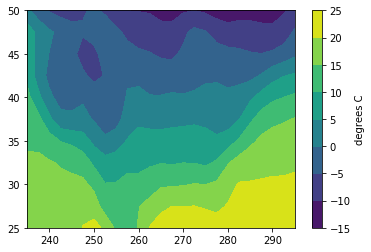

In [10]:
cf = mp.contourf(lon_reg,lat_reg,tas_obs_clim)
cbar = mp.colorbar(cf, label='degrees C')

# Calculate surface temperature timeseries
- Calculate 2m air temperature averaged over a specified region, for a specified period and season
- Modified from code above...
- Observe the trend

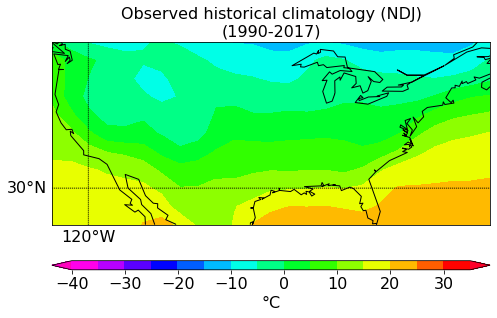

In [11]:
my_fontsize = 16

fig = mp.figure(figsize=(7,6)) # create a figure object
ax = fig.add_subplot(111) # add a single axis to that figure, which will become the map

# create a map projection for the axis; 

# map = basemap.Basemap(projection='robin', lon_0=180., resolution='c',ax=ax) # 'robin': Robinson projection
map = basemap.Basemap(llcrnrlon=lon_start,
                      llcrnrlat=lat_start,
                      urcrnrlon=lon_end,
                      urcrnrlat=lat_end,
                      projection='cyl',
                      lon_0=180.,
                      resolution='c',
                      ax=ax)

# draw coastlines
map.drawcoastlines()

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = numpy.arange(-60.,61.,30.) # 30 degree increment, from -60 to 60 
meridians = numpy.arange(0.,361.,60.) # 60 degree increment, from 0 to 360
map.drawparallels(parallels, labels=[1,0,0,0], fontsize=my_fontsize)
map.drawmeridians(meridians, labels=[0,0,0,1], fontsize=my_fontsize)

# Generate 2D lat/lon grid from 1D lat/lon
lons,lats = numpy.meshgrid(lon[lon_indices],lat[lat_indices])
xi,yi = map(lons, lats)

# Draw temperature map
contour_levels = numpy.arange(-40,36,5) # show temperature between -40 and 35 (deg-C) with 5-deg increment
tas_map = map.contourf(xi,yi,tas_obs_clim,cmap='gist_rainbow_r', levels=contour_levels, extend='both') # use gist_rainbow colormap; try 'gist_rainbow_r'

# Append colorbar to the bottom of figure
cbar = map.colorbar(tas_map, location='bottom', pad=0.5)
cbar.ax.tick_params(labelsize=my_fontsize) # change the fontsize of the colorbar tick labels
cbar.set_label(u'\N{DEGREE SIGN}C', fontsize=my_fontsize) # add a label to the colorbar

# Add a title to the figure
ax.set_title('Observed historical climatology ('+season+')\n' + '('+str(start_year)+'-'+str(end_year)+')', fontsize=my_fontsize)

fig.tight_layout() # make the figure compact; try comment this line

# ==================================================

# **User-specified Cells 2**

NB: the season, region etc. is specified independently here. To coordinate with the maps above make them the same as in User-specified Cells 1 (or if you're rerunning from the beginning you can comment out the repeated lines).
 
* Specify start and end year of time series

In [12]:
start_year = 1990
end_year = 2017 # inclusive

* Specify the season (or create your own, using a list of months)

In [13]:
season='NDJ'
months=[11,12,1]

#season = 'ANN'
#months = [1,2,3,4,5,6,7,8,9,10,11,12]

* Pick latitude and longitude ranges for the regional average

In [14]:
# Specify latitude (-90~90) and longitude (0~360), start<end
# Global has: lat_start = -90  lat_end = 90  lon_start = 0   lon_end =360
lat_start = 25
lat_end = 50
lon_start = 235
lon_end = 295

# Values for a box containing: 
#    Contiguous US would be: lat_start = 25  lat_end = 50   lon_start = 235   lon_end = 295
#    Contiguous Europe: lat_start = 35  lat_end = 55   lon_start = 0   lon_end = 60
#    Southeast Asia: lat_start = -15  lat_end = 30   lon_start = 90   lon_end = 120

# ==================================================

## Use the time/season, lat/lon, and region info to take average temperature over

In [15]:
# Adapted from previous cell
# Convert time_variable to calendar (year,month,day,hour,minute) format
time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, calendar='standard')

# Subset latitude and longitude
lon_indices = (lon>=lon_start) & (lon<=lon_end)
lat_indices = (lat>=lat_start) & (lat<=lat_end)
#
lon_reg=lon[lon_indices]
lat_reg=lat[lat_indices]
#
tas_obs_data_reg = tas_obs_data[:,lat_indices,:][:,:,lon_indices]

# Generate latitudinal weights for spatial averaging
weights_1d = numpy.cos((numpy.pi/180.)*lat_reg)
weights_2d = numpy.tile(weights_1d, reps=(lon_reg.shape[0],1)).T
weights_3d = numpy.broadcast_to(weights_2d,
                                (time_indices.shape[0],
                                 lat_reg.shape[0],
                                 lon_reg.shape[0]))

# Average over the region
tas_timeseries_reg = numpy.sum(tas_obs_data_reg*weights_3d, axis=(1,2))\
                    /numpy.sum(weights_3d, axis=(1,2))

#### Calculate the rolling 3-monthly mean timeseries ######

# how to implement a rolling mean with numpy:
tas_rolling = numpy.convolve(tas_timeseries_reg, \
                             numpy.ones((len(months),))/len(months),mode='same')  #convolve timeseries with equally weighted boxcar
tas_rolling[:len(months)] = numpy.nan #throw out the boundary effects of rolling mean operator
tas_rolling[-len(months):] = numpy.nan

# Sample the desired season
time_indices = numpy.array([t.year in range(start_year, end_year+1) and t.month==months[0] \
                            for t in time_variable_converted])
tas_timeseries = tas_rolling[time_indices]

### Plot regional avg. temperature timeseries

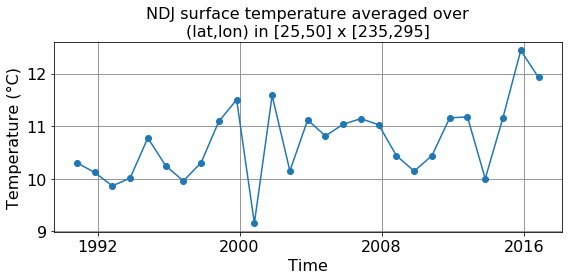

In [16]:

c_d_time = [nc_time_axis.CalendarDateTime(item, "360_day") \
            for item in time_variable_converted[time_indices]] # make datetime object compatible with matplotlib

my_fontsize = 16

fig = mp.figure(figsize=(8,4))
ax = fig.add_subplot(111)

ax.plot(c_d_time,tas_timeseries,marker='o',linestyle='-')
ax.grid(color='0.5', linestyle='-')
ax.tick_params(labelsize=my_fontsize)
ax.set_xlabel('Time', fontsize=my_fontsize)
ax.set_ylabel('Temperature ('+u'\N{DEGREE SIGN}'+'C)', fontsize=my_fontsize)
ax.set_title(season + ' surface temperature averaged over\n(lat,lon) in ['+str(lat_start)+','+\
             str(lat_end)+'] x ['+str(lon_start)+','+str(lon_end)+']', \
             fontsize=my_fontsize)
fig.tight_layout()